In [112]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf

from scipy.stats import ttest_ind

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

from EDA_func import *
from stats_func import *
from modeling_func import *
#from deep_modeling_func import *

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'tensorflow'

In [95]:
pitches_2015 = pd.read_csv('pitches/pitches_processed_2015.csv', index_col=0)
pitches_2016 = pd.read_csv('pitches/pitches_processed_2016.csv', index_col=0)
pitches_2017 = pd.read_csv('pitches/pitches_processed_2017.csv', index_col=0)
pitches_2018 = pd.read_csv('pitches/pitches_processed_2018.csv', index_col=0)

In [96]:
pitches_2015.head()

,Unnamed: 0.1,ab_id,b_count,b_score,batter_id,batter_side,code,g_id,inning,on1b,...,FS,FT,IN,KC,KN,PO,SC,SI,SL,UN
0,0,2.015000e+09,0,0,444876,True,C,201500001.0,1,False,...,0.0,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0
1,1,2.015000e+09,0,0,444876,True,F,201500001.0,1,False,...,0.0,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0
2,2,2.015000e+09,0,0,444876,True,B,201500001.0,1,False,...,0.0,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0
3,3,2.015000e+09,1,0,444876,True,D,201500001.0,1,False,...,0.0,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0
4,4,2.015000e+09,0,0,450314,True,F,201500001.0,1,True,...,0.0,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0


In [97]:
pitches_2015.columns

Index(['Unnamed: 0.1', 'ab_id', 'b_count', 'b_score', 'batter_id',
       'batter_side', 'code', 'g_id', 'inning', 'on1b', 'on2b', 'on3b',
       'p_score', 'pitch_type', 'pitcher_id', 'pitcher_side', 'ptype', 'px',
       'pz', 's_count', 'top', 'target', 'pitcher_ahead', 'pitcher_behind',
       'CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN', 'KC', 'KN',
       'PO', 'SC', 'SI', 'SL', 'UN'],
      dtype='object')

In [98]:
pitches_2015.pitch_type.unique()

array(['FF', 'SL', 'FT', 'CH', 'CU', 'FO', 'FC', 'SI', 'PO', 'FS', 'KC',
       'IN', 'EP', 'UN', 'KN', 'SC', 'FA'], dtype=object)

In [99]:
df_list = [pitches_2015,pitches_2016,pitches_2017,pitches_2018]

In [100]:
def data_wrangling(data_frames):
    '''
    Wrangles data for all 4 dataframes in one function. data_frames must be a list of dataframes.
    '''
    wrangled_df_list = []

    for df in data_frames:
        
        ball_4 = df[df.b_count == 4].index
        df.drop(ball_4, axis = 0, inplace=True)
        df.replace(True, 1, inplace=True)
        
        df.drop(df.index[0], axis = 0, inplace=True)
        
        #Fastball Pitches
        df['pitch_type'].replace(['FF', 'FT', 'SI'], 'FB', inplace=True)
        
        #Breaking Pitches
        df['pitch_type'].replace(['CU', 'FC', 'KC', 'SL', 'SC'], 'BB', inplace=True)
        
        #Offspeed Picthes
        df['pitch_type'].replace(['CH', 'EP', 'FS', 'KN'], 'OS', inplace=True)
        
        #Other Picthes
        df['pitch_type'].replace(['FO', 'PO', 'IN', 'UN', 'FA'], 'OT', inplace=True)
    
        d = {i: 0 for i in df['ab_id']}
        p_in_ab_list = []
        
        for i in df['ab_id']:
            if i in d.keys():
                d[i] += 1
                p_in_ab_list.append(d[i])
                
        df['p_in_ab'] = p_in_ab_list
        
        wrangled_df_list.append(df)
    
    return wrangled_df_list

In [101]:
wrangled_df_list = data_wrangling(df_list)

In [102]:
cleaned_2015 = wrangled_df_list[0]
cleaned_2016 = wrangled_df_list[1]
cleaned_2017 = wrangled_df_list[2]
cleaned_2018 = wrangled_df_list[3]

In [103]:
cleaned_2015.head()

,Unnamed: 0.1,ab_id,b_count,b_score,batter_id,batter_side,code,g_id,inning,on1b,...,FT,IN,KC,KN,PO,SC,SI,SL,UN,p_in_ab
1,1,2.015000e+09,0,0,444876,1.0,F,201500001.0,1,0.0,...,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,1
2,2,2.015000e+09,0,0,444876,1.0,B,201500001.0,1,0.0,...,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,2
3,3,2.015000e+09,1,0,444876,1.0,D,201500001.0,1,0.0,...,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,3
4,4,2.015000e+09,0,0,450314,1.0,F,201500001.0,1,1.0,...,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,1
5,5,2.015000e+09,0,0,450314,1.0,F,201500001.0,1,1.0,...,0.227614,0.0,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,2


In [104]:
cleaned_2016.head()

,Unnamed: 0.1,ab_id,b_count,b_score,batter_id,batter_side,code,g_id,inning,on1b,...,FT,IN,KC,KN,PO,SC,SI,SL,UN,p_in_ab
1,1,2.016000e+09,1,1,543807,1.0,B,201600001.0,1,0.0,...,0.104724,0.000732,0.0,0.0,0.0,0.0,0.0,0.203222,0.0,1
2,2,2.016000e+09,2,1,543807,1.0,B,201600001.0,1,0.0,...,0.104724,0.000732,0.0,0.0,0.0,0.0,0.0,0.203222,0.0,2
3,3,2.016000e+09,3,1,543807,1.0,C,201600001.0,1,0.0,...,0.104724,0.000732,0.0,0.0,0.0,0.0,0.0,0.203222,0.0,3
4,4,2.016000e+09,3,1,543807,1.0,E,201600001.0,1,0.0,...,0.104724,0.000732,0.0,0.0,0.0,0.0,0.0,0.203222,0.0,4
5,5,2.016000e+09,0,1,608324,1.0,F,201600001.0,1,0.0,...,0.104724,0.000732,0.0,0.0,0.0,0.0,0.0,0.203222,0.0,1


In [105]:
cleaned_2017.head()

,Unnamed: 0.1,ab_id,b_count,b_score,batter_id,batter_side,code,g_id,inning,on1b,...,FS,FT,KC,KN,PO,SC,SI,SL,UN,p_in_ab
1,1,2.017000e+09,0,0,593160,1.0,B,201700001.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.285666,0.0,0.0,1
2,2,2.017000e+09,1,0,593160,1.0,F,201700001.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.285666,0.0,0.0,2
3,3,2.017000e+09,1,0,593160,1.0,F,201700001.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.285666,0.0,0.0,3
4,4,2.017000e+09,1,0,593160,1.0,X,201700001.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.285666,0.0,0.0,4
5,5,2.017000e+09,0,0,466320,0.0,S,201700001.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.285666,0.0,0.0,1


In [106]:
cleaned_2018.head()

,ab_id,b_count,b_score,batter_id,batter_side,code,g_id,inning,on1b,on2b,...,FO,FS,FT,KC,KN,PO,SC,SI,SL,p_in_ab
1,2018000001,0,0,445055,0.0,B,201800001,1,0.0,0.0,...,0.0,0.0,0.0,0.107928,0.0,0.0,0.0,0.00314,0.210754,1
2,2018000001,1,0,445055,0.0,D,201800001,1,0.0,0.0,...,0.0,0.0,0.0,0.107928,0.0,0.0,0.0,0.00314,0.210754,2
3,2018000002,0,0,593160,1.0,C,201800001,1,1.0,0.0,...,0.0,0.0,0.0,0.107928,0.0,0.0,0.0,0.00314,0.210754,1
4,2018000002,0,0,593160,1.0,S,201800001,1,1.0,0.0,...,0.0,0.0,0.0,0.107928,0.0,0.0,0.0,0.00314,0.210754,2
5,2018000002,0,0,593160,1.0,B,201800001,1,1.0,0.0,...,0.0,0.0,0.0,0.107928,0.0,0.0,0.0,0.00314,0.210754,3


In [107]:
combined_df = pd.concat([cleaned_2015, cleaned_2016, cleaned_2017, cleaned_2018], sort=False)
combined_df = combined_df.reset_index().drop('index', axis=1)
combined_df['year'] = combined_df['ab_id'].astype(str).str[:4].astype(int)

In [108]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2855208 entries, 0 to 2855207
Data columns (total 43 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0.1    float64
 1   ab_id           float64
 2   b_count         int64  
 3   b_score         int64  
 4   batter_id       int64  
 5   batter_side     float64
 6   code            object 
 7   g_id            float64
 8   inning          int64  
 9   on1b            float64
 10  on2b            float64
 11  on3b            float64
 12  p_score         int64  
 13  pitch_type      object 
 14  pitcher_id      int64  
 15  pitcher_side    float64
 16  ptype           object 
 17  px              float64
 18  pz              float64
 19  s_count         int64  
 20  top             float64
 21  target          int64  
 22  pitcher_ahead   float64
 23  pitcher_behind  float64
 24  CH              float64
 25  CU              float64
 26  EP              float64
 27  FA              float64
 28  FC          

In [109]:
combined_df.describe()

,Unnamed: 0.1,ab_id,b_count,b_score,batter_id,batter_side,g_id,inning,on1b,on2b,...,IN,KC,KN,PO,SC,SI,SL,UN,p_in_ab,year
count,2.136451e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,...,1.417221e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.855208e+06,2.136451e+06,2.855208e+06,2.855208e+06
mean,3.561151e+05,2.016602e+09,8.797233e-01,2.355406e+00,5.201964e+05,5.812953e-01,2.016522e+08,5.001994e+00,3.025013e-01,1.845739e-01,...,4.372637e-03,2.330499e-02,3.943671e-03,2.199487e-04,3.953711e-05,8.496596e-02,1.579628e-01,2.667976e-05,2.893233e+00,2.016510e+03
std,2.056475e+05,1.117336e+06,9.649234e-01,2.591649e+00,8.122504e+04,4.933469e-01,1.115828e+05,2.667007e+00,4.593412e-01,3.879516e-01,...,6.038946e-03,7.339949e-02,5.641278e-02,6.238881e-04,8.824307e-04,1.869596e-01,1.372083e-01,2.544126e-04,1.726823e+00,1.115809e+00
min,1.000000e+00,2.015000e+09,0.000000e+00,0.000000e+00,1.125260e+05,0.000000e+00,2.015000e+08,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.015000e+03
25%,1.780385e+05,2.016003e+09,0.000000e+00,0.000000e+00,4.577270e+05,0.000000e+00,2.016000e+08,3.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.016000e+03
50%,3.560760e+05,2.017003e+09,1.000000e+00,2.000000e+00,5.193170e+05,1.000000e+00,2.017000e+08,5.000000e+00,0.000000e+00,0.000000e+00,...,2.612671e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.544656e-01,0.000000e+00,3.000000e+00,2.017000e+03
75%,5.341140e+05,2.018001e+09,1.000000e+00,4.000000e+00,5.922610e+05,1.000000e+00,2.018000e+08,7.000000e+00,1.000000e+00,0.000000e+00,...,5.826657e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.504368e-01,0.000000e+00,4.000000e+00,2.018000e+03
max,7.192320e+05,2.018186e+09,3.000000e+00,2.500000e+01,6.736330e+05,1.000000e+00,2.018025e+08,1.900000e+01,1.000000e+00,1.000000e+00,...,2.666667e-01,5.593220e-01,8.725728e-01,3.389831e-02,3.157895e-02,9.142857e-01,1.000000e+00,6.250000e-02,2.100000e+01,2.018000e+03


In [110]:
get_plots(combined_df, 'p_in_ab', lst=df_list)

Loading BokehJS ...

Loading BokehJS ...

In [65]:
get_plots(combined_df, 'b_count')

Loading BokehJS ...

Loading BokehJS ...

In [66]:
get_plots(combined_df, 's_count')

Loading BokehJS ...

Loading BokehJS ...

In [67]:
get_plots(combined_df, 'batter_side')

Loading BokehJS ...

Loading BokehJS ...

In [69]:
combined_df['runners_on'] = combined_df.loc[:,['on1b', 'on2b', 'on3b']].sum(axis=1).astype(int)
get_plots(combined_df, 'runners_on')

Loading BokehJS ...

Loading BokehJS ...

In [71]:
get_plots(combined_df, 'inning', lst=df_list)

Loading BokehJS ...

Loading BokehJS ...

In [73]:
combined_df.head()

,Unnamed: 0.1,ab_id,b_count,b_score,batter_id,batter_side,code,g_id,inning,on1b,...,KC,KN,PO,SC,SI,SL,UN,p_in_ab,year,runners_on
0,1.0,2.015000e+09,0,0,444876,1.0,F,201500001.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,1,2015,0
1,2.0,2.015000e+09,0,0,444876,1.0,B,201500001.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,2,2015,0
2,3.0,2.015000e+09,1,0,444876,1.0,D,201500001.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,3,2015,0
3,4.0,2.015000e+09,0,0,450314,1.0,F,201500001.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,1,2015,1
4,5.0,2.015000e+09,0,0,450314,1.0,F,201500001.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.149969,0.0,2,2015,1


In [75]:
combined_df['score_diff'] = combined_df['b_score'] - combined_df['p_score']

In [76]:
range_diff = combined_df.score_diff.min() - combined_df.score_diff.max()
-range_diff

48

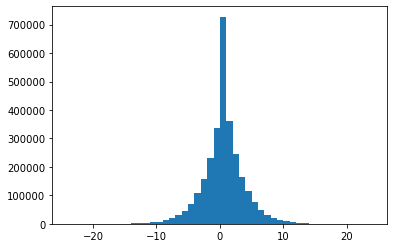

In [77]:
plt.hist(combined_df['score_diff'], bins = -range_diff )
plt.show()

95% percentile for pitches that are FB: [0.01364939 0.02363699]
95% percentile for pitches that are not FB: [0.11015725 0.12207866]


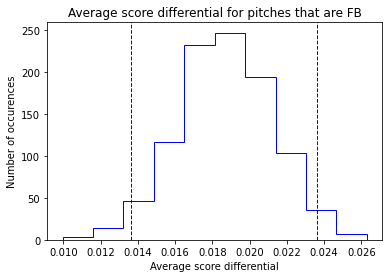

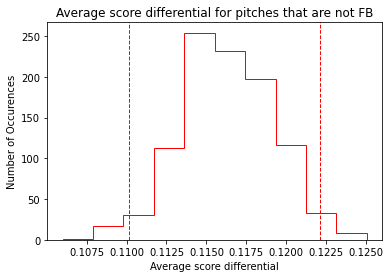

Ttest_indResult(statistic=22.343128553712074, pvalue=1.4410855859229022e-110)


In [78]:
bootstrap_test(combined_df, 'FB')

95% percentile for pitches that are BB: [0.09738397 0.10936832]
95% percentile for pitches that are not BB: [0.03811376 0.04725653]


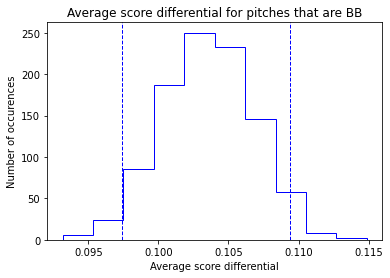

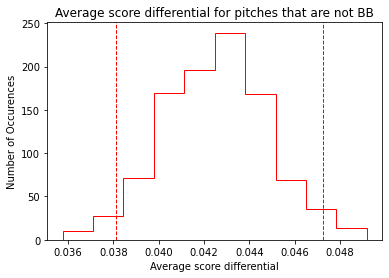

Ttest_indResult(statistic=-35.87108544099095, pvalue=1.092286002311925e-281)


In [79]:
bootstrap_test(combined_df, 'BB')

95% percentile for pitches that are OS: [0.11717563 0.13755626]
95% percentile for pitches that are not OS: [0.04862195 0.05673416]


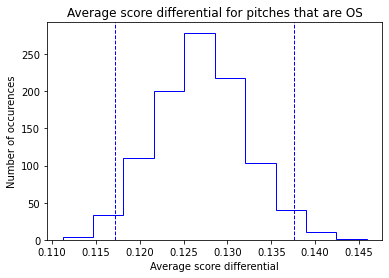

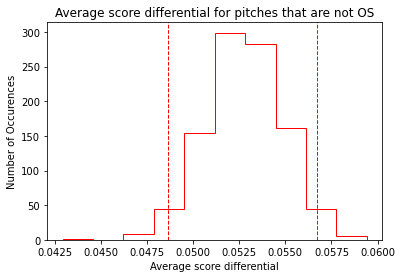

Ttest_indResult(statistic=23.489059843894026, pvalue=6.235827373076842e-122)


In [80]:
bootstrap_test(combined_df, 'OS')

95% percentile for pitches that are OT: [1.10945656 1.2057038 ]
95% percentile for pitches that are not OT: [0.0552129  0.06253302]


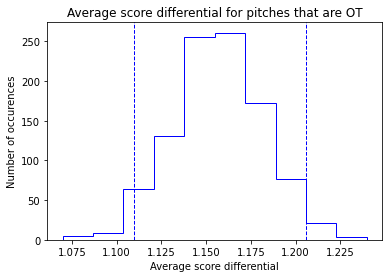

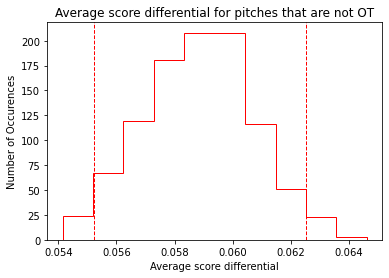

Ttest_indResult(statistic=-40.865394797167994, pvalue=0.0)


In [81]:
bootstrap_test(combined_df, 'OT')

In [82]:
df_FB = combined_df.copy()
df_FB['pitch_type'] = df_FB.apply(lambda row:change_pitch_type(row['pitch_type'], 'FB'), axis=1)
df_FB['pitch_type']

logit_FB = sm.Logit(df_FB['pitch_type'], df_FB[['b_count', 's_count']]).fit()
logit_FB.summary()

Optimization terminated successfully.
         Current function value: 0.682123
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855208
Model:                          Logit   Df Residuals:                  2855206
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:                0.005822
Time:                        14:01:01   Log-Likelihood:            -1.9476e+06
converged:                       True   LL-Null:                   -1.9590e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b_count        0.3162      0.001    245.380      0.000       0.314       0.319
s_count       -0.2123      0.001   -155.233      0.000      -0.215      -0.210
==============================================================================
"""

In [83]:
df_BB = combined_df.copy()
df_BB['pitch_type'] = df_BB.apply(lambda row:change_pitch_type(row['pitch_type'], 'BB'), axis=1)
df_BB['pitch_type']

logit_BB = sm.Logit(df_BB['pitch_type'], df_BB[['b_count', 's_count']]).fit()
logit_BB.summary()

Optimization terminated successfully.
         Current function value: 0.647539
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855208
Model:                          Logit   Df Residuals:                  2855206
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:                -0.03812
Time:                        14:02:10   Log-Likelihood:            -1.8489e+06
converged:                       True   LL-Null:                   -1.7810e+06
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b_count       -0.4860      0.001   -347.051      0.000      -0.489      -0.483
s_count       -0.0220      0.001    -15.742      0.000      -0.025      -0.019
==============================================================================
"""

In [84]:
df_OS = combined_df.copy()
df_OS['pitch_type'] = df_OS.apply(lambda row:change_pitch_type(row['pitch_type'], 'OS'), axis=1)
df_OS['pitch_type']

logit_OS = sm.Logit(df_OS['pitch_type'], df_OS[['b_count', 's_count']]).fit()
logit_OS.summary()

Optimization terminated successfully.
         Current function value: 0.504012
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855208
Model:                          Logit   Df Residuals:                  2855206
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:                 -0.3578
Time:                        14:03:21   Log-Likelihood:            -1.4391e+06
converged:                       True   LL-Null:                   -1.0599e+06
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
b_count       -0.6355      0.002   -352.325      0.000      -0.639      -0.632
s_count       -0.7943      0.002   -436.972      0.000      -0.798      -0.791
==============================================================================
"""

In [85]:
df_FB = combined_df.copy()
df_FB['pitch_type'] = df_FB.apply(lambda row:change_pitch_type(row['pitch_type'], 'FB'), axis=1)
df_FB['pitch_type']

logit_FB = sm.Logit(df_FB['pitch_type'], df_FB['runners_on']).fit()
logit_FB.summary()

Optimization terminated successfully.
         Current function value: 0.691440
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855208
Model:                          Logit   Df Residuals:                  2855207
Method:                           MLE   Df Model:                            0
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:               -0.007756
Time:                        14:04:29   Log-Likelihood:            -1.9742e+06
converged:                       True   LL-Null:                   -1.9590e+06
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
runners_on     0.1206      0.001     98.378      0.000       0.118       0.123
==============================================================================
"""

In [86]:
df_BB = combined_df.copy()
df_BB['pitch_type'] = df_BB.apply(lambda row:change_pitch_type(row['pitch_type'], 'BB'), axis=1)
df_BB['pitch_type']

logit_BB = sm.Logit(df_BB['pitch_type'], df_BB['runners_on']).fit()
logit_BB.summary()

Optimization terminated successfully.
         Current function value: 0.670625
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855208
Model:                          Logit   Df Residuals:                  2855207
Method:                           MLE   Df Model:                            0
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:                -0.07513
Time:                        14:05:25   Log-Likelihood:            -1.9148e+06
converged:                       True   LL-Null:                   -1.7810e+06
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
runners_on    -0.4591      0.001   -341.388      0.000      -0.462      -0.456
==============================================================================
"""

In [87]:
df_OS = combined_df.copy()
df_OS['pitch_type'] = df_OS.apply(lambda row:change_pitch_type(row['pitch_type'], 'OS'), axis=1)
df_OS['pitch_type']

logit_OS = sm.Logit(df_OS['pitch_type'], df_OS['runners_on']).fit()
logit_OS.summary()

Optimization terminated successfully.
         Current function value: 0.567874
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             pitch_type   No. Observations:              2855208
Model:                          Logit   Df Residuals:                  2855207
Method:                           MLE   Df Model:                            0
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:                 -0.5298
Time:                        14:06:21   Log-Likelihood:            -1.6214e+06
converged:                       True   LL-Null:                   -1.0599e+06
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
runners_on    -1.4131      0.002   -640.441      0.000      -1.417      -1.409
==============================================================================
"""

In [111]:
get_model_accuracies(combined_df, 'pitch_type')

KeyError: "['id'] not found in axis"

In [ ]:
get_model_stats(combined_df, 'pitch_type')

In [ ]:
get_classification_report(combined_df, 'pitch_type', sample_df=True, sample_size=10000)

In [ ]:
get_classification_report(combined_df, 'pitch_type', sample_df=True, sample_size=100000)

In [ ]:
gradient_boost(combined_df, 'pitch_type')

In [ ]:
gradient_boost(combined_df, 'pitch_type', resample=True, bb_mult=.75, os_mult=.5, sample_df=True, sample_size=100000)

In [ ]:
gradient_boost(combined_df, 'pitch_type', resample=True, bb_mult=.875, os_mult=.75, sample_df=True, sample_size=100000)

In [ ]:
gradient_boost(combined_df, 'pitch_type', resample=True, bb_mult=1, os_mult=1, sample_df=True, sample_size=100000)

# NEURAL NETWORK

In [ ]:
X_train, X_test, y_train, y_test = split_data(combined_df, 'pitch_type', sample_df=True, sample_size=1000000)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(15,15,15,15,15,15,15,15), max_iter=10000, random_state=11)

In [ ]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test) * 100, 2)}%')
print('\n')
print('MLP Classifier Classification report')
print(classification_report(y_test, y_pred))

In [ ]:
y_train.value_counts()

In [ ]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0] / 1.5), 
                              'OS': int(y_train.value_counts().values[0] / 2)}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

y_tr_res.value_counts()

In [ ]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test) * 100, 2)}%')
print('\n')
print('MLP Classifier Classification report')
print(classification_report(y_test, res_pred))

In [ ]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0] / 1.25), 
                              'OS': int(y_train.value_counts().values[0] / 1.5)}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

In [ ]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test) * 100, 2)}%')
print('\n')
print('MLP Classifier Classification report')
print(classification_report(y_test, res_pred))

In [113]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test) * 100, 2)}%')
print('\n')
print('MLP Classifier Classification report')
print(classification_report(y_test, res_pred))

NameError: name 'mlp' is not defined

In [114]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0]), 
                              'OS': int(y_train.value_counts().values[0])}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

NameError: name 'SMOTE' is not defined

In [ ]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(f'Test set accuracy: {round(mlp.score(X_test, y_test) * 100, 2)}%')
print('\n')
print('MLP Classifier Classification report')
print(classification_report(y_test, res_pred))